In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection  import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

import xgboost as xgb

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords

from textblob import TextBlob, Word, Blobber

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from tqdm import tqdm
from bs4 import BeautifulSoup
import warnings
import copy

warnings.filterwarnings('ignore')
stop_words = stopwords.words('english')
pd.options.display.max_columns = 30
%matplotlib inline

from nltk.stem import PorterStemmer
#from keras.preprocessing.text import Tokenizer

#tokenizer = Tokenizer(num_words=5000)

In [2]:
%ls ../input/project/project/project/

README.md      load_train_data.py           requirements.txt
data_reviews/  pretrained_word_embeddings/


In [3]:
###Change Working Directory###

import os
os.getcwd()
#os.chdir('project/project') 

'/kaggle/working'

In [4]:
x_test = pd.read_csv('../input/project/project/project/data_reviews/x_test.csv')
x_test.head()

,website_name,text
0,amazon,It only recognizes the Phone as its storage de...
1,amazon,Disappointing accessory from a good manufacturer.
2,amazon,The one big drawback of the MP3 player is that...
3,amazon,This particular model would not work with my M...
4,amazon,If the two were seperated by a mere 5+ ft I st...


In [5]:
x_train = pd.read_csv('../input/project/project/project/data_reviews/x_train.csv')
x_train.head()

,website_name,text
0,amazon,Oh and I forgot to also mention the weird colo...
1,amazon,THAT one didn't work either.
2,amazon,Waste of 13 bucks.
3,amazon,"Product is useless, since it does not have eno..."
4,amazon,None of the three sizes they sent with the hea...


In [6]:
y_train = pd.read_csv('../input/project/project/project/data_reviews/y_train.csv')
y_train.head()

,is_positive_sentiment
0,0
1,0
2,0
3,0
4,0


In [7]:
###LOWER CASE############
x_train["text"] = (x_train["text"].apply(lambda x: " ".join(x.lower() for x in x.split())))
x_test["text"] = (x_test["text"].apply(lambda x: " ".join(x.lower() for x in x.split())))

In [8]:
# Removing punctuation
x_train["text"] = x_train["text"].str.replace('[^\w\s]','')
x_test["text"] = x_test["text"].str.replace('[^\w\s]','')

In [9]:
####lEMENTIZATIOO#############
x_train["text"]  = (x_train["text"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])))
x_test["text"]  = (x_test["text"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])))

In [10]:
X_train_sentence, X_test_sentence, y_train_sentence, y_test_sentence = train_test_split( x_train['text'],y_train['is_positive_sentiment'],test_size=0.1, random_state = 0)

In [11]:
embeddings_index = {}
#f = open('pretrained_word_embeddings/glove.6B.300d.txt',encoding="utf8")
f = open('../input/project/project/project/pretrained_word_embeddings/glove.6B.50d.txt',encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:07, 54999.92it/s]

Found 400000 word vectors.


In [12]:
def sent2vec(s,size):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return list(np.zeros(size))
    return list(v / np.sqrt((v ** 2).sum()))

In [13]:
xtrain_glove = np.array([sent2vec(x,50) for x in X_train_sentence])
xvalid_glove = np.array([sent2vec(x,50) for x in X_test_sentence])
x_train_all = np.array([sent2vec(x,50) for x in x_train['text']])
x_test_all = np.array([sent2vec(x,50) for x in x_test['text']])

In [14]:
y_train_all = y_train['is_positive_sentiment'].values

In [15]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    Log loss, aka logistic loss or cross-entropy loss.
    This is the loss function used in (multinomial) logistic regression and 
    extensions of it such as neural networks, defined as the negative log-likelihood of the true labels 
    given a probabilistic classifier’s predictions. The log loss is only defined for two or more labels.
    Accuracy is the count of predictions where your predicted value equals the actual value. 
    Accuracy is not always a good indicator because of its yes or no nature.
    Log Loss takes into account the uncertainty of your prediction based on how much it varies from the actual label. 
    This gives us a more nuanced view into the performance of our model.
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [16]:
grids = {}
accuracies = {}

In [17]:
# Fitting a simple Logistic Regression on TFIDF#########
def grid_search_best_params(model_name, pipeline, params, xtrain, ytrain, xvalid, yvalid, X, Y):
    grid = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1,refit='accuracy',scoring=['accuracy','neg_log_loss','roc_auc'])
    grid.fit(X, Y)
    predictions = grid.predict_proba(xvalid)
    grids[model_name] = copy.deepcopy(grid)
    #print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
    y_pred_test = grid.predict(xvalid)
    y_test_proba = grid.predict_proba(xvalid)
    print("Log Loss for %s on Test with Embedding: %s"%(model_name,log_loss(yvalid, y_pred_test)))
    print("ROC AUC for %s on Test with Embedding: %s"%(model_name,roc_auc_score(yvalid, y_test_proba.T[1])))
    print("Accuracy for %s on Test with Embedding: %s"%(model_name,accuracy_score(yvalid, y_pred_test)))
    y_pred_train=grid.predict(xtrain)
    y_train_proba = grid.predict_proba(xtrain)
    print("Log Loss for %s on Training with Embedding: %s"%(model_name,log_loss(ytrain, y_pred_train)))
    print("ROC AUC for %s on Training with Embedding: %s"%(model_name,roc_auc_score(ytrain, y_train_proba.T[1])))
    print("Accuracy for %s on Training with Embedding: %s"%(model_name, accuracy_score(ytrain,y_pred_train)))
    print('Best Score : %.2f'%(grid.best_score_*100))
    print('Best Paramerter Settings : ',grid.best_params_)
    #print("ROC Area Under Curve in % : ",cross_val_score(pipeline_lr, X, Y, scoring="roc_auc", cv=5)*100)
    conf_mat = confusion_matrix(yvalid, y_pred_test)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    accuracies = {'Train Accuracy':accuracy_score(ytrain,y_pred_train), 
                  'Test Accuracy':accuracy_score(yvalid, y_pred_test),
                  'Best Accuracy': grid.best_score_,
                  'Train Log Loss':log_loss(ytrain, y_pred_train), 
                  'Test Log Loss':log_loss(yvalid, y_pred_test),
                  'Train ROC AUC': roc_auc_score(ytrain, y_train_proba.T[1]), 
                  'Test ROC AUC': roc_auc_score(yvalid, y_test_proba.T[1]),
                  'Best Param Settings' :grid.best_params_}
    return accuracies

Log Loss for LogisticRegression_Embedding on Test with Embedding: 7.62741307022155
ROC AUC for LogisticRegression_Embedding on Test with Embedding: 0.8471883492439551
Accuracy for LogisticRegression_Embedding on Test with Embedding: 0.7791666666666667
Log Loss for LogisticRegression_Embedding on Training with Embedding: 7.403536933817075
ROC AUC for LogisticRegression_Embedding on Training with Embedding: 0.8573439727834932
Accuracy for LogisticRegression_Embedding on Training with Embedding: 0.7856481481481481
Best Score : 77.21
Best Paramerter Settings :  {'logisticregression__C': 10, 'logisticregression__penalty': 'l2'}


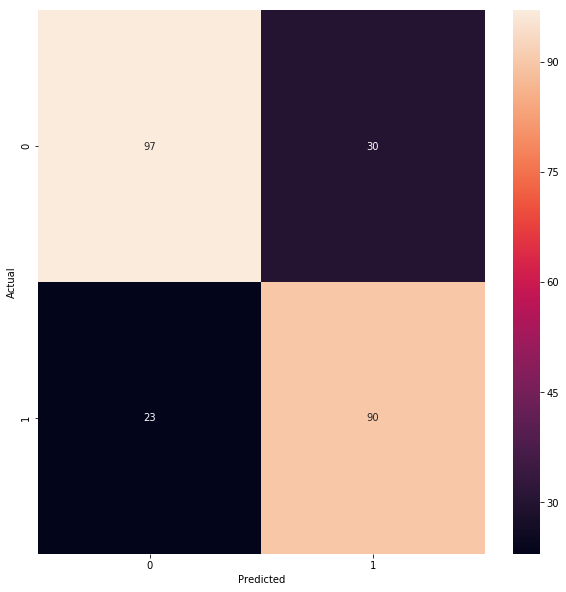

In [18]:
params_lr = {'logisticregression__C': [0.01, 0.1, 0.5,1, 10, 100],
             'logisticregression__penalty': ['l1','l2'],
          }
lr = make_pipeline(LogisticRegression())

accuracies['LogisticRegression(Embedding)'] = grid_search_best_params('LogisticRegression_Embedding', lr, params_lr,xtrain_glove,y_train_sentence,xvalid_glove,y_test_sentence,x_train_all,y_train_all)

In [19]:
params_svc = {#'svc__kernel': ['rbf','poly','sigmoid'],
                'svc__C': [0.01, 0.1, 0.5, 1, 10, 100, 10/x_train_all.shape[1]],
                'svc__gamma' : [1/x_train_all.shape[1],'auto','scale'],
                }
svc = make_pipeline(SVC(probability=True))

##accuracies['SVC(Embedding)'] = grid_search_best_params('SVC',svc, params_svc,xtrain_glove,y_train_sentence,xvalid_glove,y_test_sentence,x_train_all,y_train_all)

In [20]:
params_nb = {
            'multinomialnb__alpha': [0.1, .5, 1.0 , 10],
            }
nb = make_pipeline(MultinomialNB())

#accuracies['NaiveBayes(Embedding)'] = grid_search_best_params('NaiveBayes',nb, params_nb,xtrain_glove,y_train_sentence,xvalid_glove,y_test_sentence,x_train_all,y_train_all)

Log Loss for RandomForest_Embedding on Test with Embedding: 9.992007221626413e-16
ROC AUC for RandomForest_Embedding on Test with Embedding: 1.0
Accuracy for RandomForest_Embedding on Test with Embedding: 1.0
Log Loss for RandomForest_Embedding on Training with Embedding: 0.04797052277071027
ROC AUC for RandomForest_Embedding on Training with Embedding: 0.9999957131258087
Accuracy for RandomForest_Embedding on Training with Embedding: 0.9986111111111111
Best Score : 76.75
Best Paramerter Settings :  {'randomforestclassifier__bootstrap': False, 'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 100}


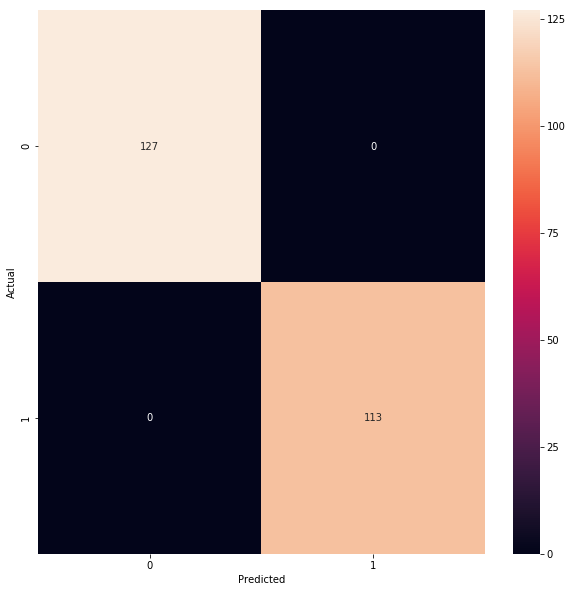

In [21]:
sqrt_features = int(np.sqrt(x_train_all.shape[1]))
params_rf = {'randomforestclassifier__n_estimators': [sqrt_features//2,sqrt_features,sqrt_features*2,sqrt_features*4,100, 200,500],
             'randomforestclassifier__max_depth':[None,3,4,5],
             'randomforestclassifier__min_samples_leaf': [0.1,0.2,0.3,0.4,0.5, 1],
             'randomforestclassifier__bootstrap' : [True, False],
            }
rf = make_pipeline(RandomForestClassifier())

accuracies['RandomForest(Embedding)'] = grid_search_best_params('RandomForest_Embedding',rf, params_rf,xtrain_glove,y_train_sentence,xvalid_glove,y_test_sentence,x_train_all,y_train_all)

Log Loss for ExtremeGradientBoosting_Embedding on Test with Embedding: 3.885668982578758
ROC AUC for ExtremeGradientBoosting_Embedding on Test with Embedding: 0.9369381924604556
Accuracy for ExtremeGradientBoosting_Embedding on Test with Embedding: 0.8875
Log Loss for ExtremeGradientBoosting_Embedding on Training with Embedding: 4.749132469507598
ROC AUC for ExtremeGradientBoosting_Embedding on Training with Embedding: 0.9368371956640841
Accuracy for ExtremeGradientBoosting_Embedding on Training with Embedding: 0.8625
Best Score : 75.62
Best Paramerter Settings :  {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 2, 'xgbclassifier__n_estimators': 200}


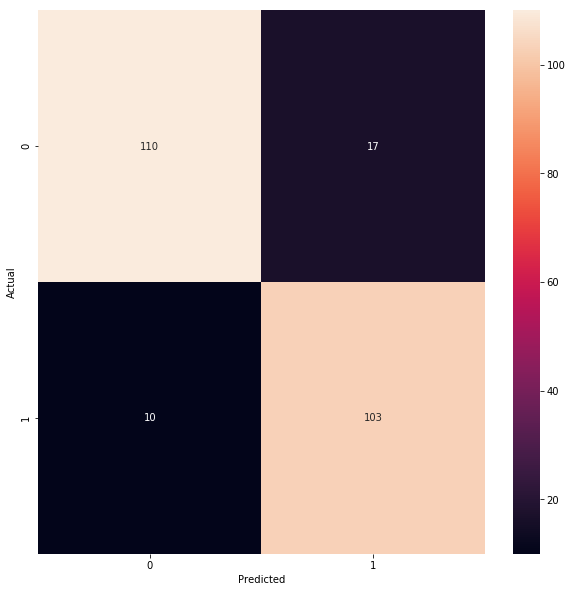

In [22]:
sqrt_features = int(np.sqrt(x_train_all.shape[1]))
params_xgb = {'xgbclassifier__n_estimators': [sqrt_features,sqrt_features*2, 100, 200 ],
                'xgbclassifier__learning_rate': [0.001,0.01,0.1,0.3],
                'xgbclassifier__max_depth' : [2, 3, 4, 5,],
                }
pipeline_xgb = make_pipeline(xgb.XGBClassifier())

accuracies['ExtremeGradientBoosting(Embedding)'] = grid_search_best_params('ExtremeGradientBoosting_Embedding',pipeline_xgb, params_xgb,xtrain_glove,y_train_sentence,xvalid_glove,y_test_sentence,x_train_all,y_train_all)

In [23]:
## We'll now use best parameters we found out above from grid search and plot model accuracy.
df = pd.DataFrame(accuracies)
df = df.transpose()
df = df.reset_index()
df = df.rename(columns={'index':'model_name'})
df

,model_name,Best Accuracy,Best Param Settings,Test Accuracy,Test Log Loss,Test ROC AUC,Train Accuracy,Train Log Loss,Train ROC AUC
0,LogisticRegression(Embedding),0.772083,"{'logisticregression__C': 10, 'logisticregress...",0.779167,7.62741,0.847188,0.785648,7.40354,0.857344
1,RandomForest(Embedding),0.7675,"{'randomforestclassifier__bootstrap': False, '...",1,9.99201e-16,1,0.998611,0.0479705,0.999996
2,ExtremeGradientBoosting(Embedding),0.75625,"{'xgbclassifier__learning_rate': 0.1, 'xgbclas...",0.8875,3.88567,0.936938,0.8625,4.74913,0.936837


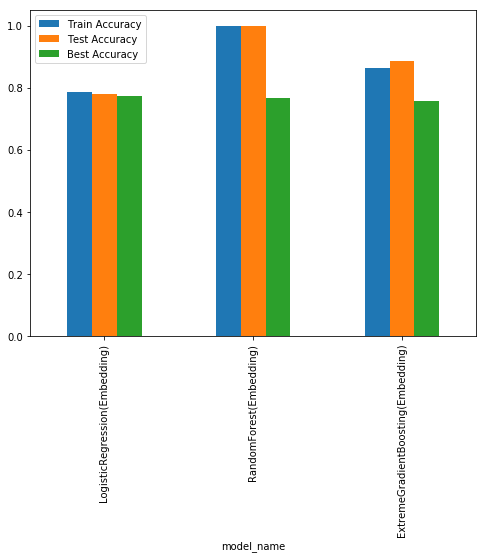

In [24]:
df.plot(x='model_name',y=['Train Accuracy', 'Test Accuracy','Best Accuracy'], kind='bar', figsize=(8,6))

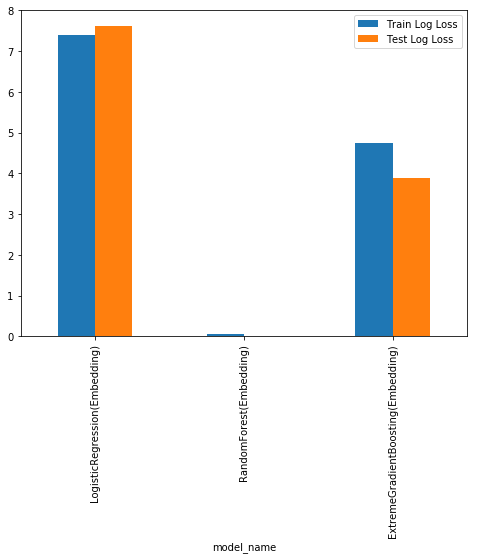

In [25]:
df.plot(x='model_name',y=['Train Log Loss', 'Test Log Loss'], kind='bar', figsize=(8,6))

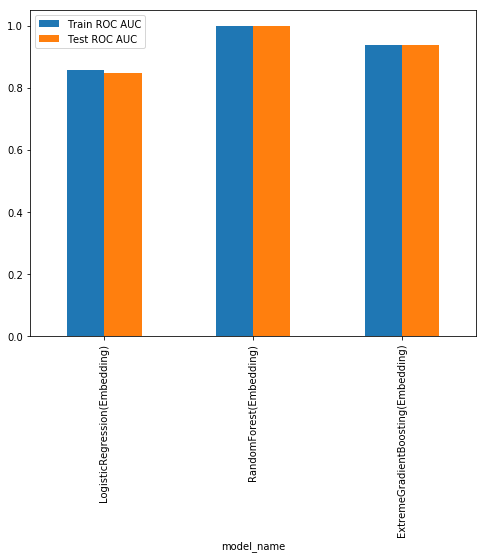

In [26]:
df.plot(x='model_name',y=['Train ROC AUC', 'Test ROC AUC'], kind='bar', figsize=(8,6))

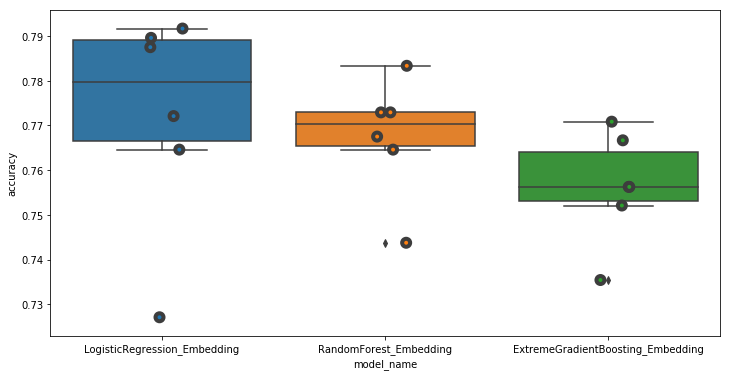

In [27]:
## We'll now use best parameters we found out above from grid search and plot model accuracy.
plt.figure(figsize=(12,6))
CV=5
cv_df = pd.DataFrame(index=range(CV * len(grids)))
entries = []
for model_name, model in grids.items():
    #model_name = model.__class__.__name__
    accuracies = df_lr = pd.DataFrame(model.cv_results_)
    df_lr = df_lr[df_lr.params == model.best_params_]
    #print(df_lr.columns)
    accuracies = df_lr[['split0_test_accuracy','split1_test_accuracy','split2_test_accuracy','split3_test_accuracy','split4_test_accuracy','mean_test_accuracy']].values[0]
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=4)
plt.show()

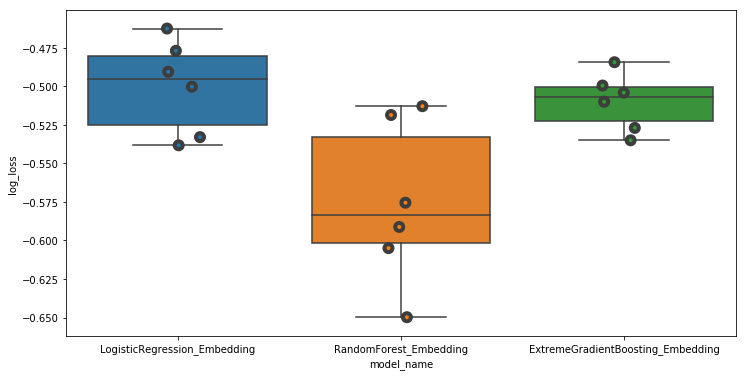

In [28]:
## We'll now use best parameters we found out above from grid search and plot model accuracy.
plt.figure(figsize=(12,6))
cv_df = pd.DataFrame(index=range(CV * len(grids)))
entries = []
for model_name, model in grids.items():
    #model_name = model.__class__.__name__
    df_lr = pd.DataFrame(model.cv_results_)
    df_lr = df_lr[df_lr.params == model.best_params_]
    #print(df_lr.columns)
    losses = df_lr[['split0_test_neg_log_loss','split1_test_neg_log_loss','split2_test_neg_log_loss','split3_test_neg_log_loss','split4_test_neg_log_loss','mean_test_neg_log_loss']].values[0]
    for fold_idx, loss in enumerate(losses):
        entries.append((model_name, fold_idx, loss))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'log_loss'])

sns.boxplot(x='model_name', y='log_loss', data=cv_df)
sns.stripplot(x='model_name', y='log_loss', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=4)
plt.show()

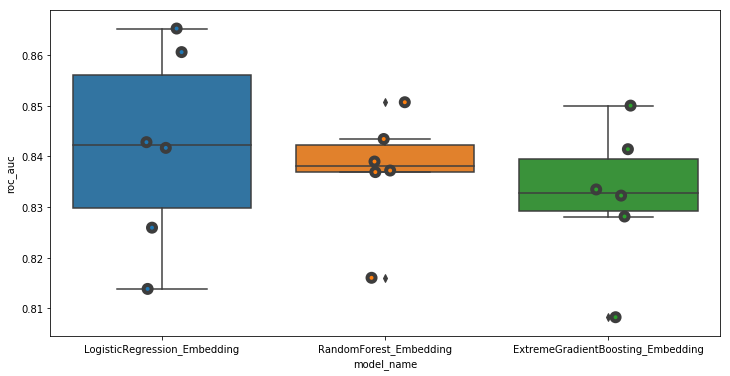

In [29]:
## We'll now use best parameters we found out above from grid search and plot model accuracy.
plt.figure(figsize=(12,6))
cv_df = pd.DataFrame(index=range(CV * len(grids)))
entries = []
for model_name, model in grids.items():
    #model_name = model.__class__.__name__
    df_lr = pd.DataFrame(model.cv_results_)
    df_lr = df_lr[df_lr.params == model.best_params_]
    #print(df_lr.columns)
    roc_aucs = df_lr[['split0_test_roc_auc','split1_test_roc_auc','split2_test_roc_auc','split3_test_roc_auc','split4_test_roc_auc','mean_test_roc_auc']].values[0]
    for fold_idx, roc_auc in enumerate(roc_aucs):
        entries.append((model_name, fold_idx, roc_auc))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'roc_auc'])

sns.boxplot(x='model_name', y='roc_auc', data=cv_df)
sns.stripplot(x='model_name', y='roc_auc', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=4)
plt.show()

In [30]:
df

,model_name,Best Accuracy,Best Param Settings,Test Accuracy,Test Log Loss,Test ROC AUC,Train Accuracy,Train Log Loss,Train ROC AUC
0,LogisticRegression(Embedding),0.772083,"{'logisticregression__C': 10, 'logisticregress...",0.779167,7.62741,0.847188,0.785648,7.40354,0.857344
1,RandomForest(Embedding),0.7675,"{'randomforestclassifier__bootstrap': False, '...",1,9.99201e-16,1,0.998611,0.0479705,0.999996
2,ExtremeGradientBoosting(Embedding),0.75625,"{'xgbclassifier__learning_rate': 0.1, 'xgbclas...",0.8875,3.88567,0.936938,0.8625,4.74913,0.936837


In [31]:
for model_name, model in grids.items():
    print(model_name + ' 5 Fold Log Loss(Error)')
    df_lr = pd.DataFrame(model.cv_results_)
    df_lr = df_lr[df_lr.params == model.best_params_]
    errors = df_lr[['split0_test_neg_log_loss','split1_test_neg_log_loss','split2_test_neg_log_loss','split3_test_neg_log_loss','split4_test_neg_log_loss','mean_test_neg_log_loss']].values[0]
    print(errors)

LogisticRegression_Embedding 5 Fold Log Loss(Error)
[-0.47695084 -0.5329853  -0.49058553 -0.5382666  -0.46252993 -0.50026364]
RandomForest_Embedding 5 Fold Log Loss(Error)
[-0.6497776  -0.60496045 -0.51289699 -0.51859491 -0.59123254 -0.5754925 ]
ExtremeGradientBoosting_Embedding 5 Fold Log Loss(Error)
[-0.49949047 -0.535019   -0.50409459 -0.52697294 -0.48437403 -0.50999021]


In [32]:
for model_name, model in grids.items():
    print(model_name + '5 Fold ROC AUC')
    df_lr = pd.DataFrame(model.cv_results_)
    df_lr = df_lr[df_lr.params == model.best_params_]
    roc_aucs = df_lr[['split0_test_roc_auc','split1_test_roc_auc','split2_test_roc_auc','split3_test_roc_auc','split4_test_roc_auc','mean_test_roc_auc']].values[0]
    print(roc_aucs)

LogisticRegression_Embedding5 Fold ROC AUC
[0.860625   0.81383681 0.84282986 0.8259375  0.86527778 0.84170139]
RandomForest_Embedding5 Fold ROC AUC
[0.85072049 0.81603299 0.84345486 0.83900174 0.8369184  0.83722569]
ExtremeGradientBoosting_Embedding5 Fold ROC AUC
[0.84144097 0.80824653 0.83348958 0.82814236 0.85005208 0.83227431]


In [33]:
for model_name, model in grids.items():
    print(model_name+' 5 Fold Accuracies')
    df_lr = pd.DataFrame(model.cv_results_)
    df_lr = df_lr[df_lr.params == model.best_params_]
    accuracies = df_lr[['split0_test_accuracy','split1_test_accuracy','split2_test_accuracy','split3_test_accuracy','split4_test_accuracy','mean_test_accuracy']].values[0]
    print(accuracies)

LogisticRegression_Embedding 5 Fold Accuracies
[0.79166667 0.72708333 0.7875     0.76458333 0.78958333 0.77208333]
RandomForest_Embedding 5 Fold Accuracies
[0.78333333 0.74375    0.76458333 0.77291667 0.77291667 0.7675    ]
ExtremeGradientBoosting_Embedding 5 Fold Accuracies
[0.76666667 0.73541667 0.75625    0.75208333 0.77083333 0.75625   ]


In [34]:
%ls

__notebook__.ipynb  __output__.json


In [35]:
for model_name, grid in grids.items():
    submission_predictions = grid.predict_proba(x_test_all)[:,1]
    np.savetxt("yproba_part2_%s.txt"%model_name, submission_predictions,newline='\r\n')
    #print(display.HTML('<a href="yproba_part1_%s.txt" target="_blank">Y_TEST_PROBA_PART1_%s</a>'%(model_name,model_name)))

In [36]:
%ls

__notebook__.ipynb
__output__.json
yproba_part2_ExtremeGradientBoosting_Embedding.txt
yproba_part2_LogisticRegression_Embedding.txt
yproba_part2_RandomForest_Embedding.txt
